## Importing modules

In [1]:
import numpy as np
import xarray as xr

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from tqdm.notebook import trange, tqdm

In [2]:
from utils.dataset import ClimateHackDataset
from utils.loss import MS_SSIMLoss
from utils.utils import *
from submission.model import Model
from config import config, results_config

In [4]:
create_files(results_config.values())
save_logs(config, config['logs_path'])

### Loading the dataset

In [5]:
dataset = xr.open_dataset(
    config['data_path'],
    engine="zarr",
    chunks="auto",  # Load the data as a Dask array
)

print(dataset)

<xarray.Dataset>
Dimensions:  (time: 173624, y: 891, x: 1843)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T00:05:00 ... 2021-11-07T15:50:00
  * x        (x) float32 2.8e+04 2.7e+04 2.6e+04 ... -1.813e+06 -1.814e+06
    x_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
  * y        (y) float32 4.198e+06 4.199e+06 4.2e+06 ... 5.087e+06 5.088e+06
    y_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
Data variables:
    data     (time, y, x) int16 dask.array<chunksize=(22, 891, 1843), meta=np.ndarray>


## Visualising the data

You may be curious what these 1841x891 "high resolution visible" satellite images actually look like! 

Here is an example:

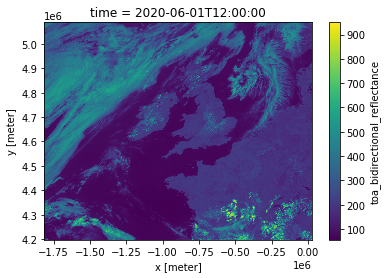

In [6]:
dataset["data"].sel(time="2020-06-01 12:00").plot()

As part of your challenge, you are given twelve 128x128 images taken five minutes apart corresponding to some region inside the 1841x891 image above, e.g.

In [7]:
# fig, ax = plt.subplots(1, 12, figsize=(15,3))

# for i, d in enumerate(["2020-07-04 12:00", "2020-07-04 12:05", "2020-07-04 12:10", "2020-07-04 12:15", "2020-07-04 12:20", "2020-07-04 12:25", "2020-07-04 12:30", "2020-07-04 12:35", "2020-07-04 12:40", "2020-07-04 12:45", "2020-07-04 12:50", "2020-07-04 12:55"]):
#     ax[i].imshow(dataset["data"].sel(time=d).isel(x=slice(128, 256), y=slice(128, 256)).to_numpy(), cmap='viridis')
#     ax[i].get_xaxis().set_visible(False)
#     ax[i].get_yaxis().set_visible(False)

# fig.tight_layout()
# fig.subplots_adjust(wspace=0, hspace=0)

From these, your aim is to predict the next 24 images taken five minutes apart for the centre 64x64 region of the 128x128 area. 

In [8]:
# fig, (ax1, ax2) = plt.subplots(2, 12, figsize=(16,3))

# for i, d in enumerate(["2020-07-04 13:00", "2020-07-04 13:05", "2020-07-04 13:10", "2020-07-04 13:15", "2020-07-04 13:20", "2020-07-04 13:25", "2020-07-04 13:30", "2020-07-04 13:35", "2020-07-04 13:40", "2020-07-04 13:45", "2020-07-04 13:50", "2020-07-04 13:55"]):
#     ax1[i].imshow(dataset["data"].sel(time=d).isel(x=slice(160, 224), y=slice(160, 224)).to_numpy(), cmap='viridis')
#     ax1[i].get_xaxis().set_visible(False)
#     ax1[i].get_yaxis().set_visible(False)

# for i, d in enumerate(["2020-07-04 14:00", "2020-07-04 14:05", "2020-07-04 14:10", "2020-07-04 14:15", "2020-07-04 14:20", "2020-07-04 14:25", "2020-07-04 14:30", "2020-07-04 14:35", "2020-07-04 14:40", "2020-07-04 14:45", "2020-07-04 14:50", "2020-07-04 14:55"]):
#     ax2[i].imshow(dataset["data"].sel(time=d).isel(x=slice(160, 224), y=slice(160, 224)).to_numpy(), cmap='viridis')
#     ax2[i].get_xaxis().set_visible(False)
#     ax2[i].get_yaxis().set_visible(False)

# fig.tight_layout()
# fig.subplots_adjust(wspace=0, hspace=0)

#### Dataloader

In [9]:
# Increase crops_per_slice if you want to crop out multiple 128x128 areas from the same sliding window.
# To only train on a subset of the dataset, either select what you want and pass it into ClimateHackDataset,
# set start_date and end_date to Python datetime objects, or set day_limit > 0 to the number of days from the start to read.

ch_dataset = ClimateHackDataset(dataset, crops_per_slice=1, day_limit=7)
ch_dataloader = DataLoader(ch_dataset, batch_size=config['batch_size'])

### Instantiating the model

Any models you define need to be in the `submission` folder so that they can be evaluated on DOXA. By default, they are defined in `submission/model.py`, which is where this PyTorch model is defined.

There are some huge improvements you can make to this basic model, so feel free to use this as a starting point and customise `submission/model.py` to your liking!

In [10]:
device = torch.device(config['device'])

In [11]:
model = Model().to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=config['lr'])
criterion = MS_SSIMLoss(channels=24) # produces less blurry images than nn.MSELoss()

In [12]:
writer = SummaryWriter(config['tensorboard_path'])

### Training the model

In [13]:
model = model.train()

In [14]:
train_batch = 0

In [15]:
for epoch in trange(config['num_epochs']):
    running_loss = 0
    count = 0
    for batch_coordinates, batch_features, batch_targets in tqdm(ch_dataloader):
        print(batch_targets.shape)
        print(batch_coordinates)
        optimiser.zero_grad()
        batch_predictions = model(batch_features.to(device))
        
        print(batch_targets.shape)
        
        batch_loss = criterion(batch_predictions.unsqueeze(dim=2), batch_targets.unsqueeze(dim=2).to(device))
        batch_loss.backward()

        optimiser.step()

        running_loss += batch_loss.item() * batch_predictions.shape[0]
        count += batch_predictions.shape[0]

        writer.add_scalar('Train/loss', batch_loss.item(), train_batch)
        train_batch += 1
        
        del batch_coordinates, batch_features, batch_targets, batch_predictions, batch_loss

        # print(f"Completed batch {i} of epoch {epoch + 1} with loss {batch_loss.item()} -- processed {count} image sequences ({12 * count} images)")

    
    writer.add_scalar('Train/lr', get_lr(optimizer), epoch)

    save_model(valid_epoch, model, optimizer, config['checkpoints_path'])
    # print(f"Loss for epoch {epoch + 1}/{EPOCHS}: {losses[-1]}")

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

2020-01-01 09:00:00
2020-01-01 09:20:00
2020-01-01 09:40:00
2020-01-01 10:00:00
2020-01-01 10:20:00


KeyboardInterrupt: 

### Visualising predictions

Having trained the model, it is often useful to visualise some of its predictions to ensure it is producing a sensible output.

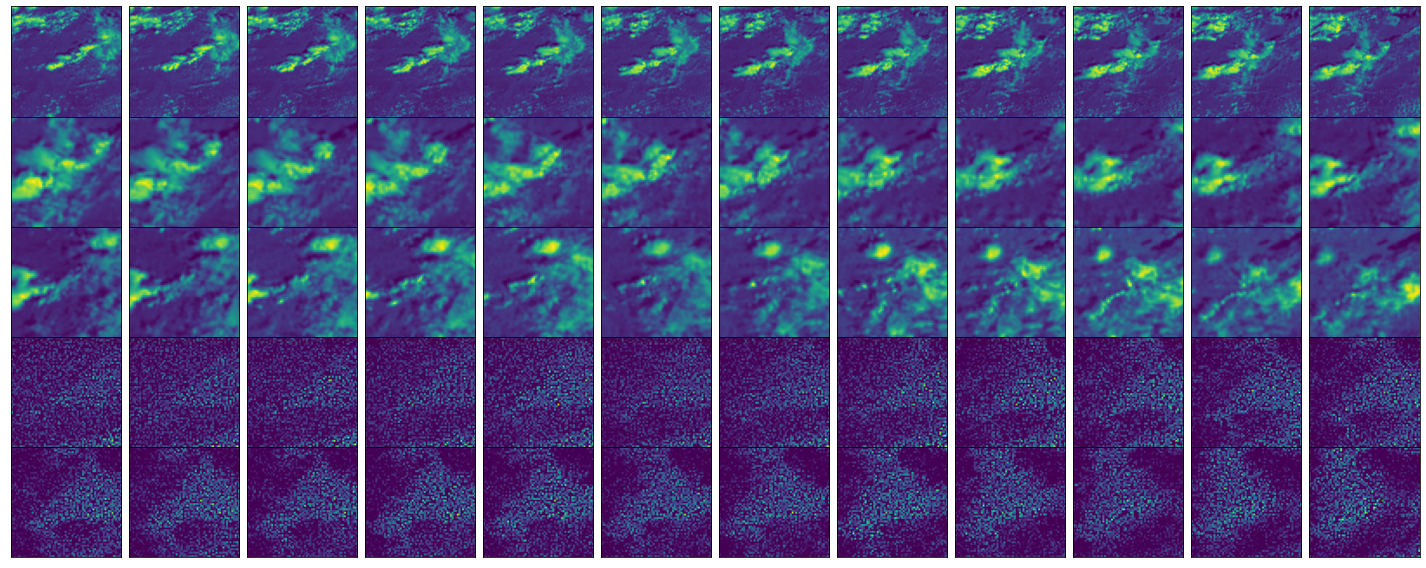

In [27]:
x = dataset["data"].sel(time=slice("2020-07-01 12:00", "2020-07-01 12:55")).isel(x=slice(128, 256), y=slice(128, 256)).to_numpy()
y = dataset["data"].sel(time=slice("2020-07-01 13:00", "2020-07-01 14:55")).isel(x=slice(160, 224), y=slice(160, 224)).to_numpy()
p = model(torch.from_numpy(x.astype(np.float32)).unsqueeze(dim=0)).detach().numpy()[0]

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 12, figsize=(20,8))

# plot the twelve 128x128 input images
for i, img in enumerate(x):
    ax1[i].imshow(img, cmap='viridis')
    ax1[i].get_xaxis().set_visible(False)
    ax1[i].get_yaxis().set_visible(False)

# plot twelve 64x64 true output images
for i, img in enumerate(y[:12]):
    ax2[i].imshow(img, cmap='viridis')
    ax2[i].get_xaxis().set_visible(False)
    ax2[i].get_yaxis().set_visible(False)

# plot twelve more 64x64 true output images
for i, img in enumerate(y[12:]):
    ax3[i].imshow(img, cmap='viridis')
    ax3[i].get_xaxis().set_visible(False)
    ax3[i].get_yaxis().set_visible(False)

# plot the twelve 64x64 predicted output images
for i, img in enumerate(p[:12]):
    ax4[i].imshow(img, cmap='viridis')
    ax4[i].get_xaxis().set_visible(False)
    ax4[i].get_yaxis().set_visible(False)

# plot twelve more 64x64 output images
for i, img in enumerate(p[12:]):
    ax5[i].imshow(img, cmap='viridis')
    ax5[i].get_xaxis().set_visible(False)
    ax5[i].get_yaxis().set_visible(False)

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

## Submitting your model to DOXA

Well done -- you made it to the end!

You are now ready to submit your model to DOXA!

If you are not already logged in, run the following command:

```bash
$ python doxa_cli.py user login
```

Finally, to submit your model, upload the entire `submission` folder into which your model was saved using the following command:

```bash
$ python doxa_cli.py agent upload climatehack ./submission
```